Download necessay dependencies (if running on desktop instead of Google Colab)

In [179]:
%pip install seaborn
%pip install numpy
%pip install pandas
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Import the necessary dependencies

In [180]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import shapiro

from sklearn.tree import DecisionTreeRegressor

Load preprocessed dataset

In [181]:
bike_data = pd.read_csv('./data/SeoulBikeData_Processed.csv', encoding='unicode_escape')

## Training Our Second Model (Decision Tree)

Splitting the Data

In [182]:
x_train, x_test, y_train, y_test = train_test_split(bike_data.drop(['Rented Bike Count'], axis=1), bike_data['Rented Bike Count'], test_size=0.2, random_state=21)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(7008, 13)
(1752, 13)
(7008,)
(1752,)


We didn't scale since decision trees are not sensitive to outliers.

In [ ]:
regressor = DecisionTreeRegressor(criterion="squared_error", random_state=21)

regressor.fit(x_train, y_train)

yhat_train = regressor.predict(x_train)
yhat_test = regressor.predict(x_test)

train_mse = mean_squared_error(y_train, yhat_train)
test_mse = mean_squared_error(y_test, yhat_test)

y_test_df = pd.DataFrame(y_test)
yhat_test_df = pd.DataFrame(yhat_test)

print(y_test_df.head())
print("===========================================")
print(yhat_test_df.head())

print('Train MSE:', train_mse)
print('Test MSE:', test_mse)

n_nodes = regressor.tree_.node_count 
print(f"Number of nodes: {n_nodes}") 
depth = regressor.get_depth() 
print(f"Depth of the tree: {depth}")
print(" Parameters: ", regressor.get_params())



      Rented Bike Count
6771                395
5878               1375
2905                453
6167               1165
6431               1357
        0
0   504.0
1  1421.0
2   502.0
3  1103.0
4  1155.0
Train MSE: 0.0
Test MSE: 87543.27739726027
Number of nodes: 13347
Depth of the tree: 32
 Parameters:  {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 21, 'splitter': 'best'}


A train mse of 0.0 screams overfitting. As warned in the documentation we got an extremely complex model with 13347 nodes and a depth of 32. 

Consequently we are limiting our max_depth as a first simple complexity constraint in the following. We try out max_depth in the range of 1 to 20.

In [184]:
for depth in range(1, 20):
    regressor = DecisionTreeRegressor(criterion="squared_error", random_state=21, max_depth=depth)
    regressor.fit(x_train, y_train)

    yhat_train = regressor.predict(x_train)
    yhat_test = regressor.predict(x_test)

    train_mse = mean_squared_error(y_train, yhat_train)
    test_mse = mean_squared_error(y_test, yhat_test)

    y_test_df = pd.DataFrame(y_test)
    yhat_test_df = pd.DataFrame(yhat_test)

    print("Depth ", depth, " Parameters: ", regressor.get_params())
    print('Train MSE:', train_mse)
    print('Test MSE:', test_mse)
    n_nodes = regressor.tree_.node_count 
    print(f"Number of nodes: {n_nodes}") 


Depth  1  Parameters:  {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 1, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 21, 'splitter': 'best'}
Train MSE: 314925.87165549694
Test MSE: 322191.75681537244
Number of nodes: 3
Depth  2  Parameters:  {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 2, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 21, 'splitter': 'best'}
Train MSE: 233048.59217233112
Test MSE: 238601.81306663583
Number of nodes: 7
Depth  3  Parameters:  {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 21, 'splitter': 

We observe that the training MSE continues to decrease. However, the test MSE continues to decrease until depth 12. Then the test MSE starts increasing. We believe that depth 12 is the optimal max depth and increasing the max depth further leads to overfitting. A total node count of 2865 is much smaller than the original 13347 nodes which means that as expected we are better of with a less complex model.

Fine-tuning Model Hyperparameters

The following code is based on https://www.geeksforgeeks.org/how-to-tune-a-decision-tree-in-hyperparameter-tuning/  

In [185]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [6, 8, 10, 12, 16, 18, 20, 22],
    'min_samples_split': [2, 10, 18, 16, 24, 30],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'criterion': ['squared_error']
}

dtree_reg = DecisionTreeRegressor(random_state=42) # Initialize a decision tree regressor
grid_search = GridSearchCV(estimator=dtree_reg, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)
best_dtree_reg = grid_search.best_estimator_ # Get the best estimator from the grid search
y_pred_train = best_dtree_reg.predict(x_train)
y_pred_test = best_dtree_reg.predict(x_test)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")
print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")

n_nodes = best_dtree_reg.tree_.node_count  
print(f"Number of nodes: {n_nodes}") 

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best parameters: {'criterion': 'squared_error', 'max_depth': 20, 'min_samples_leaf': 6, 'min_samples_split': 24}
Train MSE: 33551.060849269306
Test MSE: 65080.173307821824
Number of nodes: 1033


Since there are many hyperparameters, we used a grid search cross validation method to find the optimal hyperparameter combination based on MSE. We found that the best hyperparameter to be a max depth of 20, min sample leaf of 6 and min sample split of 24. 

For illustrative purposes we are showing our fitting graph here.
We chose the number of nodes in the decision tree for measuring the complexity of our model. Models with similar many nodes are not necessarily fitted with the same parameters as the combination of parameters (e.g.   max_depthmin_samples_split, min_samples_leaf) can be different. 
For showing the fitting graph we recompute all models in order to obtain the train mse, and test mse values. As this method is not based on cross validation (compared to the grid-search library we used beforehand), but on a fixed split, it might lead to slightly different results for the optimal model complexity. However, we clearly see that around 1000 to 1500 nodes are a reasonable model complexity. Thus our model is within the area of the minimum of the test mse curve. 
For more complex models we see an decrease of the training error however the testing error is then increasing again, which shows overfitting.  

In [186]:
max_depth =  [6, 8, 10, 12, 16, 18, 20, 22]
min_samples_split =  [2, 10, 18, 16, 24, 30]
min_samples_leaf =  [1, 2, 4, 6, 8, 10]
criterion = ['squared_error']
node_count_l = []
train_mse_l = []
test_mse_l = []
for depth in max_depth: 
    for split in min_samples_split: 
        for leaf in min_samples_leaf: 
            regressor = DecisionTreeRegressor(criterion="squared_error", random_state=21, max_depth=depth, min_samples_split=split, min_samples_leaf=leaf)
            regressor.fit(x_train, y_train)

            yhat_train = regressor.predict(x_train)
            yhat_test = regressor.predict(x_test)

            train_mse = mean_squared_error(y_train, yhat_train)
            test_mse = mean_squared_error(y_test, yhat_test)

            y_test_df = pd.DataFrame(y_test)
            yhat_test_df = pd.DataFrame(yhat_test)
            n_nodes = regressor.tree_.node_count 

            train_mse_l.append(train_mse)
            test_mse_l.append(test_mse)
            node_count_l.append(n_nodes)


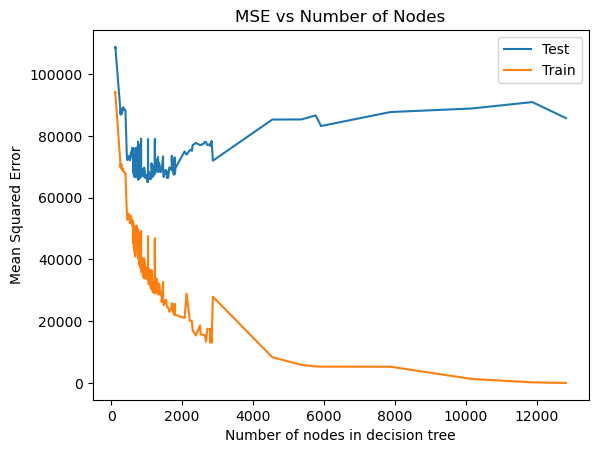

In [187]:
data_for_plot = pd.DataFrame()
data_for_plot['mse_test'] = test_mse_l
data_for_plot['mse_train'] = train_mse_l
data_for_plot['complexity'] = node_count_l
data_for_plot_sorted = data_for_plot.sort_values(by='complexity')
plt.figure()
plt.title('MSE vs Number of Nodes')
plt.plot(data_for_plot_sorted['complexity'], data_for_plot_sorted['mse_test'], label='Test')
plt.plot(data_for_plot_sorted['complexity'], data_for_plot_sorted['mse_train'], label='Train')
plt.xlabel('Number of nodes in decision tree')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

Comparing the training and testing MSE, the test MSE is higher than we anticipated. This is likely due to our model not being the best fit for the problem and/or our hyperparameter tuning wasn't exhaustive enough. Our test MSE is almost double than our training MSE which suggests a bad fitting of our model. 

Compared to our first model (Polynomial Regression), we believe our second model (Decision Tree), is more complex. Out hyperparameter-tuned model has 1033 nodes where decisions are made, while for polynomial regression a degree of two was achieving a good fit. For our next model, we want to look at neural networks. We hope that the increased complexity of neural networks will allow us to create a model that better predicts the Rented Bike Count feature. We think that neural networks better account for relations between features. In turn, this will aide in our MSE.

### Conclusion

We have found that decision trees are not the optimal model for our research question. Even when we tune our hyperparameter, the MSE for our train and test were still relatively large. The test MSE was much larger than the train MSE which points to our model being a bad fit for our problem. Therefore, our first model, polynomial regression, was much better than our second model, decision tree. 

To improve our decision tree model, we can try to do a more exhaustive hyperparameter tuning search. We can increase the granularity and the number of features tested in our hyperparameter tuning. We currently only tune the max depth, min sample in each leaf node, and min samples for splitting at a decision node since we believe those to be the most influential.

Manually preprocessing our data for the decision tree might also help. We could manually introduce thresholds for splitting the data. Another than that decision trees in comparison to polynomial regression tend to struggle more with identifying feature interaction consequently we should maybe reduce the number of features used in our model and e.g. use an overall weather score instead of the multiple weather patterns. This would also prevent our tree from becoming too large. 